## Домашнее задание: "Введение, основы нейронных сетей"

ФИО: Фадеев Роман Андреевич

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [2]:
diamonds_df = pd.read_csv('diamonds.csv')

In [3]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


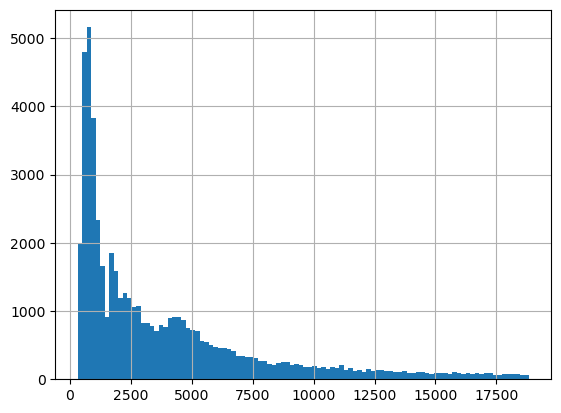

In [4]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid()

# Подготовка данных

In [5]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [6]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [7]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [8]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [9]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [11]:
reg = LinearRegression().fit(X_train, y_train)

In [12]:
y_pred = reg.predict(X_test)

In [13]:
score = r2_score(y_pred, y_test)

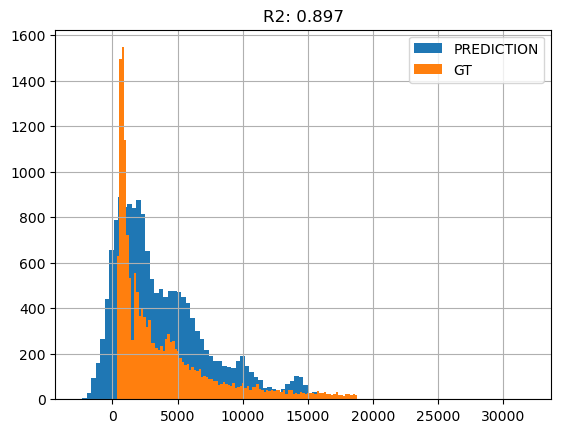

In [14]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid()

# Создаём модель MLP для задачи регрессии

In [90]:
import numpy as np

class MLPRegressor:
    def __init__(self, hidden_layer_sizes=(100,), learning_rate=0.001, max_iter=1000):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = []
        self.biases = []
        self.loss_history = []

    def _initialize_weights(self, input_size, output_size):
        layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]

        for i in range(len(layer_sizes) - 1):
            W = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(W)
            self.biases.append(b)

    def _relu(self, Z):
        return np.maximum(0, Z)
    
    def _relu_derivative(self, Z):
        return Z > 0

    def _forward(self, X):
        activations = [X]
        Zs = []
        for i in range(len(self.weights) - 1):
            Z = activations[-1] @ self.weights[i] + self.biases[i]
            Zs.append(Z)
            A = self._relu(Z)  # ReLU активация
            activations.append(A)
        
        Z = activations[-1] @ self.weights[-1] + self.biases[-1]
        Zs.append(Z)
        activations.append(Z)

        return activations, Zs

    def _compute_loss(self, y_pred, y):
        return np.mean((y_pred - y) ** 2)

    def _backward(self, X, y, activations, Zs):
        m = X.shape[0]
        dA = activations[-1] - y
        grads_w = []
        grads_b = []

        for i in reversed(range(len(self.weights))):
            dZ = dA
            dW = activations[i].T @ dZ / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            grads_w.append(dW)
            grads_b.append(db)

            if i > 0:
                dA = dZ @ self.weights[i].T * self._relu_derivative(Zs[i - 1])
        
        grads_w.reverse()
        grads_b.reverse()

        return grads_w, grads_b

    def train(self, X, y):
        input_size = X.shape[1]
        output_size = y.shape[1] if len(y.shape) > 1 else 1

        self._initialize_weights(input_size, output_size)

        for epoch in range(self.max_iter):
            activations, Zs = self._forward(X)
            y_pred = activations[-1]

            loss = self._compute_loss(y_pred, y)
            self.loss_history.append(loss)

            grads_w, grads_b = self._backward(X, y, activations, Zs)

            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * grads_w[i]
                self.biases[i] -= self.learning_rate * grads_b[i]

            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}/{self.max_iter}, Loss: {loss}')

    def predict(self, X):
        activations, _ = self._forward(X)
        return activations[-1]

# Проверяем модель MLP на выборке Diamonds

In [97]:
mlp_reg_v2 = MLPRegressor(hidden_layer_sizes=(41, 28, 14, 8), learning_rate=0.0000001, max_iter=10000)

mlp_reg_v2.train(X_train, y_train)
y_mlp_pred2 = mlp_reg_v2.predict(X_test)
mlp_score2 = r2_score(y_mlp_pred2, y_test)
print(mlp_score2)

Epoch 100/10000, Loss: 31523531.85153672
Epoch 200/10000, Loss: 31519702.840612505
Epoch 300/10000, Loss: 31512681.65524034
Epoch 400/10000, Loss: 31497904.400653996
Epoch 500/10000, Loss: 31451374.46073508
Epoch 600/10000, Loss: 31029464.291295405
Epoch 700/10000, Loss: 1892925.7362571408
Epoch 800/10000, Loss: 1280124.1009802204
Epoch 900/10000, Loss: 1140194.1967682228
Epoch 1000/10000, Loss: 1052584.2422936074
Epoch 1100/10000, Loss: 989246.6549312851
Epoch 1200/10000, Loss: 942163.1285744148
Epoch 1300/10000, Loss: 903541.4145145942
Epoch 1400/10000, Loss: 871118.5882266584
Epoch 1500/10000, Loss: 842581.5396165216
Epoch 1600/10000, Loss: 816477.8284499736
Epoch 1700/10000, Loss: 791608.9339198575
Epoch 1800/10000, Loss: 767326.1958306564
Epoch 1900/10000, Loss: 743631.9302892137
Epoch 2000/10000, Loss: 720428.935343103
Epoch 2100/10000, Loss: 698015.1183013932
Epoch 2200/10000, Loss: 676215.0997790035
Epoch 2300/10000, Loss: 655221.315209254
Epoch 2400/10000, Loss: 635536.3183375

# Сравним результаты

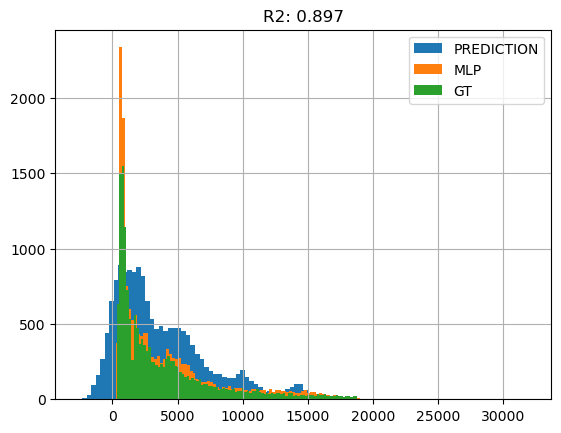

In [99]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_mlp_pred2.reshape(1, -1)[0], bins=100, label='MLP')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid()

## Выводы

- Реализован MLP;
- На тестовой выборке получен хороший R2 score: 0.9749995810572604;
- Предсказания MLP куда лучше аппроксимируют таргетную функцию, чем LinearRegression.